In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [52]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 경우
# 맥OS의 경우: plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [53]:
# Random seed
np.random.seed(42)
torch.manual_seed(42)

,exp,T,V,E,Ki,t,CF_LA,CA_LA,VF,VA
0,1,25.06,20,0.25,1.0,0.0,0.5000,0.0000,1.00,1.00
1,1,25.06,20,0.25,1.0,1.0,0.4726,0.0182,1.02,0.99
2,1,25.06,20,0.25,1.0,2.0,0.4454,0.0462,1.02,0.99
3,1,25.06,20,0.25,1.0,3.0,0.4121,0.0961,0.98,1.00
4,1,25.06,20,0.25,1.0,4.0,0.3204,0.2001,0.93,1.01
5,1,25.06,20,0.25,1.0,5.1,0.1229,0.3961,0.91,0.98


In [ ]:
def prepare_training(df):
    input_features = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA']

    scaler = StandardScaler()
    scaler.fit(df[input_features])

    dict_spline = {}
    for exp in df['exp'].unique():
        dict_spline[exp] = df[df['exp'] == exp].sort_values('t')
    
    return dict_spline, scaler

In [56]:
# Feedforward network for migration prediction
class MigrationPredictor(nn.Module):
    def __init__(self, input_node = 6, hidden_nodes = 64, hidden_layers = 3, output_nodes = 3):
        super().__init__()
        
        # Layer configuration
        layers = []
        # input layer
        layers.append(nn.Linear(input_node, hidden_nodes))
        layers.append(nn.ReLU())

        # hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(hidden_nodes, output_nodes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [57]:
# Physical Layers for State update
class PhysicalLayer:
    def __init__(self, dt = 0.1):
        self.dt = dt
    
    def update_state(self, cur_state, migration):
        # Current States
        T = cur_state[0]
        V = cur_state[1]
        E = cur_state[2]
        Ki = cur_state[3]
        CF_LA = cur_state[4]
        CA_LA = cur_state[5]
        VF = cur_state[6]
        VA = cur_state[7]
        
        # Migration
        dNLA = migration[0] * self.dt
        dVF = migration[1] * self.dt
        dVA = migration[2] * self.dt

        # Fixed variables
        nT = T
        nV = V
        nE = E
        nKi = Ki       
        
        # New Volumes
        nVF = VF + dVF
        nVA = VA + dVA

        # New Concentrations
        nCF_LA = (CF_LA*VF - dNLA)/nVF
        nCA_LA = (CA_LA*VA + dNLA)/nVA

        # New States
        new_state = cur_state.clone()
        new_state[0] = nT
        new_state[1] = nV
        new_state[2] = nE
        new_state[3] = nKi
        new_state[4] = nCF_LA
        new_state[5] = nCA_LA
        new_state[6] = nVF
        new_state[7] = nVA
        
        return new_state

In [58]:
class BMEDDataset(Dataset):
    def __init__(self, dict_spline):
        self.features = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA', 'VF', 'VA']
        self.experiments = []

        for exp_id, exp_data in dict_spline.items():
            # Save whole data of each experiment in one sample
            exp_array = exp_data[self.features].values
            times = exp_data['t'].values
            self.experiments.append({
                'init_state': exp_array[0], # initial state
                'measured_state': exp_array, # whole measurements
                'times': times # time points
            })
    
    def __len__(self):
        return len(self.experiments)
    
    def __getitem__(self, idx):
        return self.experiments[idx]

In [59]:
class BMEDModel(nn.Module):
    def __init__(self, input_node = 6, hidden_nodes = 256, hidden_layers = 10, output_nodes = 3, dt = 0.1):
        super().__init__()
        self.migration_predictor = MigrationPredictor(input_node, hidden_nodes, hidden_layers, output_nodes)
        self.physical_layer = PhysicalLayer(dt)
        self.dt = dt

    def forward(self, init_state, measured_time):
        '''
        initial_state: initial state of the experiment (batch_size, 8)
        measured_time: time points of the measurements (batch_size, n_measurements)
        '''
        # 배치 처리를 위한 초기화
        batch_size = init_state.shape[0]
        device = init_state.device
        
        # 각 배치에 대한 결과를 저장할 리스트
        all_pred_states = []
        all_measured_indices = []

        for b in range(batch_size):
            cur_state = init_state[b]  # (8,)
            cur_time = 0.0
            pred_states = []
            measured_indices = []

            # 현재 배치의 측정 시간들
            times = measured_time[b]  # (n_measurements,)
            max_time = times[-1].item()  # 스칼라 값으로 변환

            # 초기 상태 저장
            pred_states.append(cur_state.unsqueeze(0))  # (1, 8)

            while cur_time < max_time:
                migration = self.migration_predictor(cur_state[0:6])  # (1, 6) -> (1, 3)
                cur_state = self.physical_layer.update_state(cur_state, migration[0])  # (8,)
                pred_states.append(cur_state.unsqueeze(0))  # (1, 8)
                cur_time += self.dt

                # 측정 시간과 매칭
                for i, t in enumerate(times):
                    if abs(cur_time - t.item()) < self.dt/2:
                        measured_indices.append(len(pred_states) - 1)

            # 현재 배치의 예측 상태들을 스택
            pred_states = torch.cat(pred_states, dim=0)  # (n_steps, 8)
            
            all_pred_states.append(pred_states)
            all_measured_indices.append(measured_indices)

        # 가장 긴 시퀀스에 맞춰 패딩
        max_length = max(states.shape[0] for states in all_pred_states)
        padded_pred_states = []
        
        for states in all_pred_states:
            if states.shape[0] < max_length:
                padding = torch.zeros(max_length - states.shape[0], 8, device=device)
                states = torch.cat([states, padding], dim=0)
            padded_pred_states.append(states.unsqueeze(0))

        # 배치 차원으로 결합
        pred_states_batch = torch.cat(padded_pred_states, dim=0)  # (batch_size, max_length, 8)

        return pred_states_batch, all_measured_indices

In [60]:
def custom_loss(pred_states_batch, measured_indices_batch, measured_states_batch):
    '''
    pred_states_batch: (batch_size, max_length, 8)
    measured_states_batch: (batch_size, n_measurements, 8)
    measured_indices_batch: list of lists containing indices
    '''
    batch_size = pred_states_batch.shape[0]
    total_loss = 0

    for b in range(batch_size):
        pred_states = pred_states_batch[b]  # (max_length, 8)
        measured_states = measured_states_batch[b]  # (n_measurements, 8)
        indices = measured_indices_batch[b]

        for idx, measured_state in zip(indices, measured_states):
            predicted_state = pred_states[idx]
            total_loss += torch.mean((predicted_state - measured_state) ** 2)

    return total_loss / batch_size

In [61]:
def train_model(model, train_loader, num_epochs = 100000, learning_rate = 0.0001):
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    device = torch.device('cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()

            init_state = batch['init_state'].float().to(device)
            measured_state = batch['measured_state'].float().to(device)
            times = batch['times'].float().to(device)

            # Simulation
            pred_state, measured_indices = model(init_state, times)

            # Loss
            loss = custom_loss(pred_state, measured_indices, measured_state)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.8f}')

In [87]:
# Load data
df = pd.read_csv('../data/BMED_data_v6.csv')
df = df[df['exp'] == 1]
dict_spline, scaler = prepare_training(df)
dict_spline

{np.int64(1):    exp      T   V     E   Ki    t   CF_LA   CA_LA    VF    VA
 0    1  25.06  20  0.25  1.0  0.0  0.5000  0.0000  1.00  1.00
 1    1  25.06  20  0.25  1.0  1.0  0.4726  0.0182  1.02  0.99
 2    1  25.06  20  0.25  1.0  2.0  0.4454  0.0462  1.02  0.99
 3    1  25.06  20  0.25  1.0  3.0  0.4121  0.0961  0.98  1.00
 4    1  25.06  20  0.25  1.0  4.0  0.3204  0.2001  0.93  1.01
 5    1  25.06  20  0.25  1.0  5.1  0.1229  0.3961  0.91  0.98}

In [101]:
dataset = BMEDDataset(dict_spline)

features = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA','VF','VA']
experiments = []

for exp_id, exp_data in dict_spline.items():
    exp_array = exp_data[features].values
    times = exp_data['t'].values
    experiments.append({
        'init_state': exp_array[0],
        'measured_state': exp_array,
        'times': times
    })
print(experiments[0]['init_state'])
print(experiments[0]['measured_state'])
print(experiments[0]['times'])
print(dataset.experiments[0]['init_state'])
print(dataset.experiments[0]['measured_state'])
print(dataset.experiments[0]['times'])


[25.06 20.    0.25  1.    0.5   0.    1.    1.  ]
[[2.506e+01 2.000e+01 2.500e-01 1.000e+00 5.000e-01 0.000e+00 1.000e+00
  1.000e+00]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 4.726e-01 1.820e-02 1.020e+00
  9.900e-01]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 4.454e-01 4.620e-02 1.020e+00
  9.900e-01]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 4.121e-01 9.610e-02 9.800e-01
  1.000e+00]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 3.204e-01 2.001e-01 9.300e-01
  1.010e+00]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 1.229e-01 3.961e-01 9.100e-01
  9.800e-01]]
[0.  1.  2.  3.  4.  5.1]
[25.06 20.    0.25  1.    0.5   0.    1.    1.  ]
[[2.506e+01 2.000e+01 2.500e-01 1.000e+00 5.000e-01 0.000e+00 1.000e+00
  1.000e+00]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 4.726e-01 1.820e-02 1.020e+00
  9.900e-01]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 4.454e-01 4.620e-02 1.020e+00
  9.900e-01]
 [2.506e+01 2.000e+01 2.500e-01 1.000e+00 4.121e-01 9.610e-02 9.800e-01
  1.000e+00]
 [2.506e+01 2.000e+01 2

In [104]:
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)
train_loader.dataset.experiments[0]

{'init_state': array([25.06, 20.  ,  0.25,  1.  ,  0.5 ,  0.  ,  1.  ,  1.  ]),
 'measured_state': array([[2.506e+01, 2.000e+01, 2.500e-01, 1.000e+00, 5.000e-01, 0.000e+00,
         1.000e+00, 1.000e+00],
        [2.506e+01, 2.000e+01, 2.500e-01, 1.000e+00, 4.726e-01, 1.820e-02,
         1.020e+00, 9.900e-01],
        [2.506e+01, 2.000e+01, 2.500e-01, 1.000e+00, 4.454e-01, 4.620e-02,
         1.020e+00, 9.900e-01],
        [2.506e+01, 2.000e+01, 2.500e-01, 1.000e+00, 4.121e-01, 9.610e-02,
         9.800e-01, 1.000e+00],
        [2.506e+01, 2.000e+01, 2.500e-01, 1.000e+00, 3.204e-01, 2.001e-01,
         9.300e-01, 1.010e+00],
        [2.506e+01, 2.000e+01, 2.500e-01, 1.000e+00, 1.229e-01, 3.961e-01,
         9.100e-01, 9.800e-01]]),
 'times': array([0. , 1. , 2. , 3. , 4. , 5.1])}

In [62]:
# set data loader
dataset = BMEDDataset(dict_spline)
train_loader = DataLoader(dataset, batch_size = 1, shuffle = True)


In [63]:
# train model
model = BMEDModel(input_node = 6, hidden_nodes = 64, hidden_layers = 3, output_nodes = 3, dt = 0.1)
train_model(model, train_loader)

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

실험 1 시뮬레이션 결과:


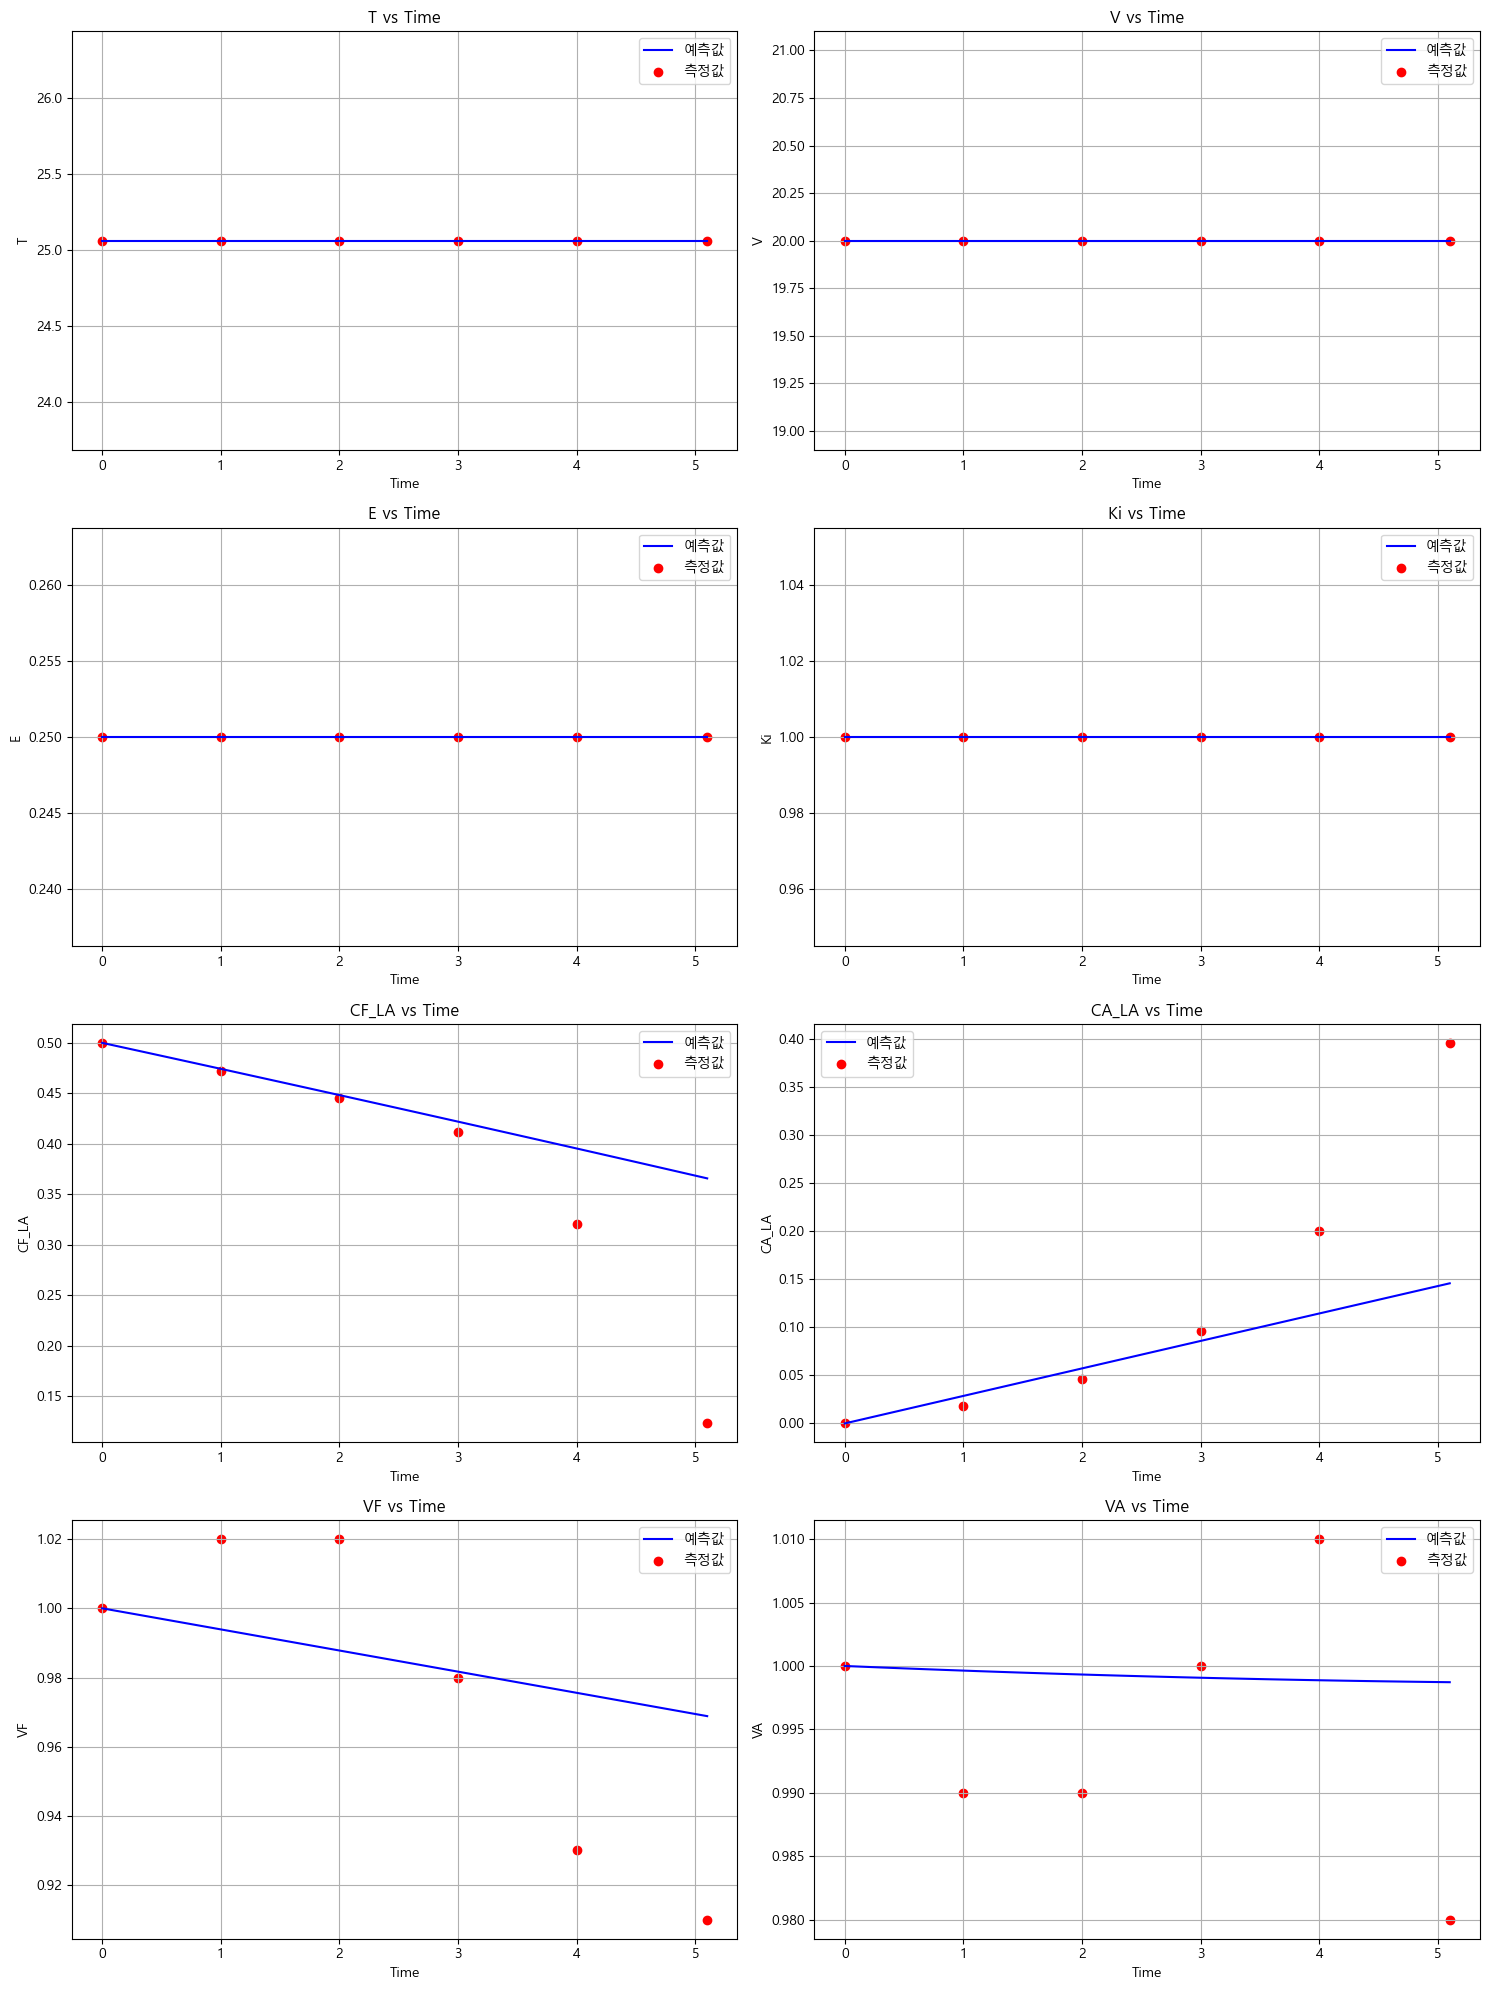

In [ ]:
import matplotlib.pyplot as plt

def simulate_and_plot(model, dataset, exp_idx=0):
    """
    학습된 모델을 사용하여 시뮬레이션을 수행하고 결과를 시각화합니다.
    
    Args:
        model: 학습된 BMED 모델
        dataset: BMEDDataset 인스턴스
        exp_idx: 시각화할 실험 인덱스 (기본값: 0)
    """
    model.eval()  # 평가 모드로 설정
    device = next(model.parameters()).device
    
    # 데이터 준비
    data = dataset[exp_idx]
    init_state = torch.tensor(data['init_state'], dtype=torch.float32).unsqueeze(0).to(device)
    times = torch.tensor(data['times'], dtype=torch.float32).unsqueeze(0).to(device)
    measured_states = torch.tensor(data['measured_state'], dtype=torch.float32).to(device)
    
    # 시뮬레이션 수행
    with torch.no_grad():
        pred_states, measured_indices = model(init_state, times)
        pred_states = pred_states[0].cpu().numpy()  # 배치 차원 제거
    
    # 측정 데이터 준비
    measured_times = data['times']
    measured_states = measured_states.cpu().numpy()
    
    # 시각화
    variables = ['T', 'V', 'E', 'Ki', 'CF_LA', 'CA_LA', 'VF', 'VA']
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()
    
    # 시뮬레이션 시간 포인트 생성
    sim_times = np.arange(0, measured_times[-1] + model.dt, model.dt)[:len(pred_states)]
    
    for i, (ax, var) in enumerate(zip(axes, variables)):
        # 예측값 플롯
        ax.plot(sim_times, pred_states[:, i], 'b-', label='예측값')
        
        # 측정값 플롯
        ax.scatter(measured_times, measured_states[:, i], c='r', marker='o', label='측정값')
        
        ax.set_title(f'{var} vs Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(var)
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# 시뮬레이션 및 시각화 실행
print("실험 1 시뮬레이션 결과:")
simulate_and_plot(model, dataset, exp_idx=0)

RuntimeError: Could not infer dtype of ellipsis